In [151]:
import cv2
import numpy as np

class SB:
    def __init__(self):
        #self.img = img
        self.sobelX = None
        self.sobelY = None
        self.sb = None

    # use kernel to filter the input image
    def kernel_filter (self, kernel):
        height, width = self.img.shape
        kernel_height, kernel_width = kernel.shape

        img_pad = np.zeros(((height+2), (width+2)), np.float32)
        img_pad[1:height+1, 1:width+1] = self.img

        window = np.zeros((kernel_height, kernel_width), np.float32)
        value = np.zeros((kernel_height, kernel_width), np.float32)
        img_filter = np.zeros((height, width))

        for row in range(1, height):
            for col in range(1, width):
                window = img_pad[(row - 1): (row + 2), (col - 1): (col + 2)]
                value = window*kernel
                img_filter[row-1, col-1] = int(value.sum())

        return img_filter

    def filter(self):
        filterX = np.array([[1, 0, -1], [2, 0, -2], [1, 0, -1]])
        filterY = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]])
        filterG = np.array([(1, 2, 1), (2, 4, 2), (1, 2, 1)], np.float32)/16

        self.sobelX = self.kernel_filter(filterX)
        self.sobelY = self.kernel_filter(filterY)

        sb = cv2.magnitude(self.sobelX, self.sobelY)
        #(self.sobelX**2 + self.sobelY**2)**0.5
        self.sb = cv2.GaussianBlur(sb, (5,5), 0)

    def threshold(self, th):
        img_thr = np.copy(self.sb)
        img_thr[img_thr >= th] = 0
        img_thr[img_thr != 0] = 255

        self.sb = img_thr

    def sobel(self, img, th=100):
        self.img = img
        self.filter()
        self.threshold(th)
        return self.sb

# example
img = cv2.imread('sample.jpg', 0)
img = cv2.resize(img, (150,200))
sb = SB()

img = sb.sobel(img)

cv2.imshow('img',img)
cv2.waitKey(0)
cv2.destroyAllWindows()

[ 3  2  3  5  3  3  2  0  0  0  0  2  5  9 12  7  8  8  4  3  5  5  5  6  5
  6  5  8 17 20 22 10 16 16 23 23 20  9  1  0  2  5  2  0  0  0  0  0]
(48,)
[  1.6   2.6   3.2   3.2   3.2   2.6   1.6   1.    0.4   0.4   1.4   3.2
   5.6   7.    8.2   8.8   7.8   6.    5.6   5.    4.4   4.8   5.2   5.4
   5.4   6.    8.2  11.2  14.4  15.4  17.   16.8  17.4  17.6  19.6  18.2
  15.2  10.6   6.4   3.4   2.    1.8   1.8   1.4   0.4   0.    0.    0. ]
(48,)
[ -5.80000000e+00  -4.80000000e+00  -2.20000000e+00   4.44089210e-16
   2.20000000e+00   3.80000000e+00   4.40000000e+00   3.40000000e+00
   8.00000000e-01  -3.20000000e+00  -8.00000000e+00  -1.08000000e+01
  -1.06000000e+01  -8.20000000e+00  -4.00000000e+00   1.40000000e+00
   5.40000000e+00   6.00000000e+00   4.40000000e+00   2.40000000e+00
   6.00000000e-01  -1.20000000e+00  -1.60000000e+00  -1.40000000e+00
  -3.60000000e+00  -8.60000000e+00  -1.42000000e+01  -1.56000000e+01
  -1.30000000e+01  -8.20000000e+00  -4.40000000e+00  -2.60000000e

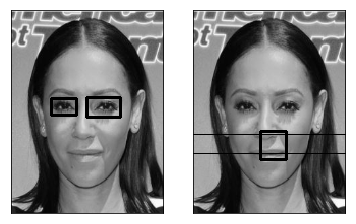

In [152]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

def eye_region(img):
    img = sb.sobel(img)
    height, width = img.shape
    h1, h2, w1, w2 = int(height/3), int(3*height/5), int(width/4), int(3*width/4)
    hist = np.zeros((h2-h1),dtype = np.uint8)

    for i in range(h1, h2):
        hist[i-h1] = (img[i,w1:w2] == 0).sum()
    center_line = hist.argmax()

    search_region = 255 - img[h1:h2, w1:w2]
    left,right = np.zeros(4), np.zeros(4)
    left_min, right_min = 99, 99
    i_left, i_right = 0, 0

    output = cv2.connectedComponentsWithStats(np.uint8(search_region), 8, cv2.CV_32S)
    stats = output[2]
    for i in range(0, stats.shape[0]):
        x_pos = stats[i,0] + int(stats[i,2]/2)
        y_pos = stats[i,1] + int(stats[i,3]/2)
        if stats[i,4] >= 30:
            #component is left eye
            if x_pos < ((w2-w1)/2):
                if abs(y_pos - center_line) < left_min:
                    left_min = abs(y_pos - center_line)
                    i_left = i
            #component is right eye
            if x_pos > ((w2-w1)/2):
                if abs(y_pos - center_line) < right_min:
                    right_min = abs(y_pos - center_line)
                    i_right = i
    left = stats[i_left, 0:4]
    left[0] += w1
    left[1] += h1
    right = stats[i_right, 0:4]
    right[0] += w1
    right[1] += h1

    return center_line+h1, left, right

def eye_detect(img_gray):
    sob = sb.sobel(img_gray)
    #img_gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    height, width = img_gray.shape
    h1, h2, w1, w2 = int(height/3), int(3*height/5), int(width/4), int(3*width/4)
    hist = np.zeros((h2-h1),dtype = np.uint8)

    for i in range(h1, h2):
        hist[i-h1] = (sob[i,w1:w2] == 0).sum()
    center_line = hist.argmax()
    
    search_region = img_gray[h1:h2, w1:w2]
    eye_cascade = cv2.CascadeClassifier('haarcascade_eye.xml')
    eyes = eye_cascade.detectMultiScale(search_region)
    for i in range(0,len(eyes)):
        eyes[i][0] += w1
        eyes[i][1] += h1
        
    if eyes[0][0] < eyes[1][0]:
        left = eyes[0]
        right = eyes[1]
    else:
        left = eyes[1]
        right = eyes[0]
        
    return center_line+h1, left, right

def nose_mouth_loc(img_gray, l_eye, r_eye):
    height, width = img.shape
    Deyes = r_eye[0] + r_eye[2] - l_eye[0]
    y1 = l_eye[1] + l_eye[3]
    y2 = h1 + int(3*Deyes/4)
    x1 = l_eye[0] + int(l_eye[2]/2)
    x2 = w1 + Deyes - int(l_eye[2]/2) - int(r_eye[2]/2)
    hist = np.zeros((y2-y1),dtype = np.uint8)
    sob = sb.sobel(img_gray)

    for i in range(y1, y2):
        hist[i-y1] = (sob[i,x1:x2] == 0).sum()
    print(hist)
    print(hist.shape)
    kernel = np.ones(5)/5
    hist = np.convolve(hist, kernel, mode="same")
    print(hist)
    print(hist.shape)
    kernel2 = np.array([-1,-1,0,1,1])
    first_d = np.convolve(hist, kernel2, mode="same")
    print (first_d)
    print(first_d.shape)
    index = np.zeros(1)
    max = np.zeros(1)
    for i in range(0,first_d.shape[0]-1):
        if first_d[i] >= 0 and first_d[i+1] < 0:
            index = np.append(index,i)
            max = np.append(max,first_d[i] - first_d[i+1])
        elif first_d[i] < 0 and first_d[i+1] >= 0:
            index = np.append(index,i)
            max = np.append(max,first_d[i+1] - first_d[i])
    print(index)
    print(max)
    i = max.argmax()
    mouth = index[i]
    max[i] = 0
    i = max.argmax()
    nose = index[i]
    print (mouth,nose)
    
    if mouth < nose:
        temp = mouth
        mouth = nose
        nose = temp
    #print (mouth,nose)
    search_region = 255 - sob[y1:y2, x1:x2]
    min = 99
    output = cv2.connectedComponentsWithStats(np.uint8(search_region), 8, cv2.CV_32S)
    stats = output[2]
    print(stats)
    for i in range(1, stats.shape[0]):
        y_pos = stats[i,1] + int(stats[i,3]/2)
        if stats[i,4] >= 30:
            if abs(y_pos - mouth) < min:
                min = abs(y_pos - mouth)
                index = i
    mouth_region = stats[index, 0:4]
    mouth_region[0] += x1
    mouth_region[1] += y1
    
    mouth += (y1)
    nose += (y1)
    
    
    return mouth, nose, mouth_region

img2 = cv2.imread("sample2.jpg",0)
img2 = cv2.resize(img2, (150,200),)
histo = eye_region(img2)
#img2 = img.copy()
cv2.rectangle(img2,           
              (histo[1][0], histo[1][1]),                 # upper left corner
              (histo[1][0]+histo[1][2], histo[1][1]+histo[1][3]),        # lower right corner
              (0, 0, 255),                  # red
              2)
cv2.rectangle(img2,           
              (histo[2][0], histo[2][1]),                 # upper left corner
              (histo[2][0]+histo[2][2], histo[2][1]+histo[2][3]),        # lower right corner
              (0, 0, 255),                  # red
              2)

img4 = cv2.imread("sample2.jpg",0)
img4 = cv2.resize(img4, (150,200),)
c,left,right = eye_detect(img4)
#cv2.rectangle(img4,(left[0],left[1]),(left[0]+left[2],left[1]+left[3]),(0,0,255),2)
#cv2.rectangle(img4,(right[0],right[1]),(right[0]+right[2],right[1]+right[3]),(0,0,255),2)

mouth,nose,mouth_region = nose_mouth_loc(img4,left,right)
img4[int(mouth),:] = 0
img4[int(nose),:] = 0
cv2.rectangle(img4,(mouth_region[0],mouth_region[1]),(mouth_region[0]+mouth_region[2],mouth_region[1]+mouth_region[3]),(0,0,255),2)
#cv2.rectangle(img4,(x1,y1),(x2,y2),(0,0,255),2)

plt.subplot(121), plt.imshow(img2, cmap="gray")
plt.title("img2"),plt.xticks([]),plt.yticks([])
plt.subplot(122), plt.imshow(img4, cmap="gray")
plt.title("img4"),plt.xticks([]),plt.yticks([])
plt.show()